# Comparison of optimizers

This notebook demonstrates and compares performace of the following optimizers on quadratic function:
- Vanila Gradient Descent
- Gradient Descent with Momentum
- RMSprop
- Adam

In [1]:
from typing import Union, Callable

import numpy as np
import matplotlib.pyplot as plt

from nn.value import Value
from nn.optimizer import VanillaGradientDescentOptimizer, MomentumOptimizer, RMSPropOptimizer, AdamOptimizer

np.random.seed(17)

In [2]:
def quadratic_form(x1: Union[Value, float], x2: Union[Value, float]):
    
    A = [
        [1, 0],
        [0, 10]
    ]
    x = [x1, x2]
    return sum(A[i][j] * x[i] * x[j] for i in range(2) for j in range(2))

Plot graph of the function to minimize

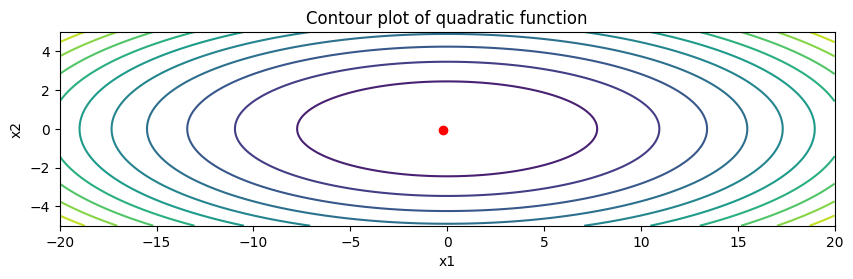

In [3]:
domain = np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-5, 5, 100))
values = quadratic_form(domain[0], domain[1])

def draw_contour(ax, func):
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.contour(domain[0], domain[1], values, 10)
    minimum = np.argmin(values.reshape(-1))
    minimum = minimum // values.shape[1], minimum % values.shape[1]
    minimum = domain[0][minimum], domain[1][minimum]
    ax.scatter([minimum[0]], [minimum[1]], color='red')
    ax.axis('scaled');

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Contour plot of quadratic function")
draw_contour(ax, quadratic_form)

Set initial values for x1 and x2

In [4]:
x1_init, x2_init = -17, -2

Run different optimizers for 10 iterations

In [5]:
def get_path(x1_init: float, x2_init: float, num_iters: int, optimizer_class: type, **kwargs):
    x1 = Value(x1_init)
    x2 = Value(x2_init)

    optimizer = optimizer_class([x1, x2], **kwargs)

    path = [(x1.data, x2.data)]
    for _ in range(num_iters):
        objective = quadratic_form(x1, x2)
        optimizer.zero_grad()
        objective.back_prop()
        optimizer.step()
        path.append((x1.data, x2.data))

    return path

num_iters = 10
vanilla_path = get_path(x1_init, x2_init, num_iters, VanillaGradientDescentOptimizer, lr=0.07)
momentum_path = get_path(x1_init, x2_init, num_iters, MomentumOptimizer, lr=0.07)
rmsprop_path = get_path(x1_init, x2_init, num_iters, RMSPropOptimizer, lr=1)
adam_path = get_path(x1_init, x2_init, num_iters, AdamOptimizer, lr=1)

Display paths

In [6]:
def draw_path(ax, path):
    for start, end in zip(path[:-1], path[1:]):
        ax.arrow(*start, *map(lambda s, e: e - s, start, end), head_width=0.5, head_length=0.5, color='black')

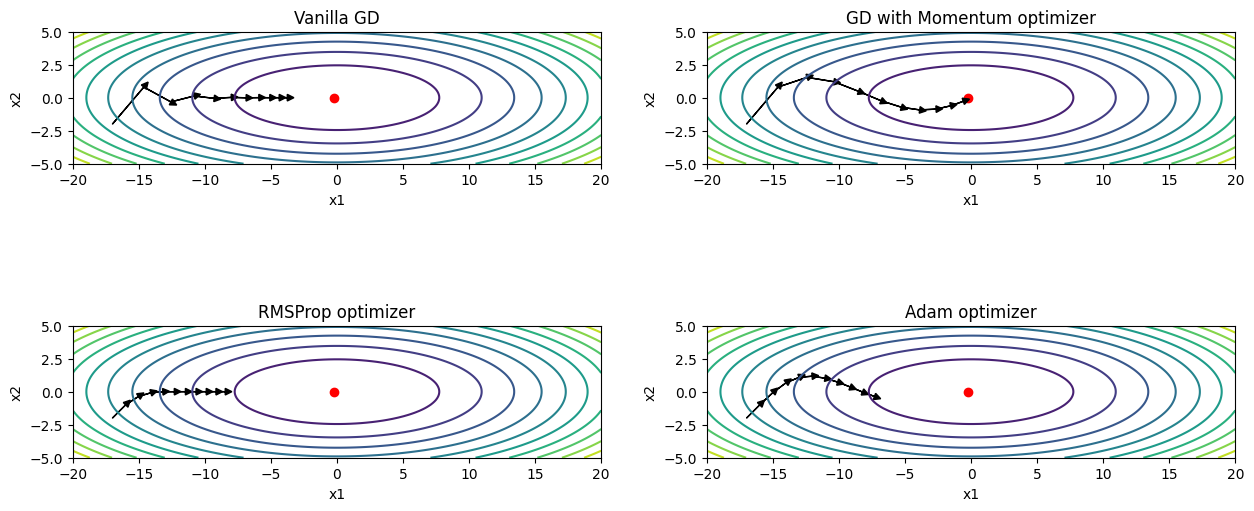

In [7]:
fig = plt.figure(figsize=(15, 7))
[ax1, ax2], [ax3, ax4] = fig.subplots(2, 2)

ax1.set_title("Vanilla GD")
draw_contour(ax1, quadratic_form)
draw_path(ax1, vanilla_path)

ax2.set_title("GD with Momentum optimizer")
draw_contour(ax2, quadratic_form)
draw_path(ax2, momentum_path)

ax3.set_title("RMSProp optimizer")
draw_contour(ax3, quadratic_form)
draw_path(ax3, rmsprop_path)

ax4.set_title("Adam optimizer")
draw_contour(ax4, quadratic_form)
draw_path(ax4, adam_path)

### Hypothesis:
> GD with Momentum will almost always work faster than the stanard gradient descent algorithm.

To check if it holds in our case, we perform the following experiment:
1. Iterate over different values of learning rate.
2. For each of the learning rates, run random number of iterations of both algorithms.
3. Check what algorithm produced smaller value

In [8]:
num_vanilla = 0
num_momentum = 0
for lr in np.linspace(0.01, 0.2, 10):
    lr = np.round(lr, 2)
    for _ in range(10):
        num_iterations = np.random.randint(7, 20)
        x1_init = np.random.rand() * 40 - 20
        x2_init = np.random.rand() * 10 - 5
        vanilla_path = get_path(x1_init, x2_init, num_iterations, VanillaGradientDescentOptimizer, lr=lr)
        momentum_path = get_path(x1_init, x2_init, num_iterations, MomentumOptimizer, lr=lr)
        
        if quadratic_form(*vanilla_path[-1]) > quadratic_form(*momentum_path[-1]):
            num_momentum += 1
        else:
            num_vanilla += 1

        # # Uncomment this to plot graphs
        # fig = plt.figure(figsize=(15, 7))
        # ax1, ax2 = fig.subplots(1, 2)

        # ax1.set_title("Naive GD")
        # draw_contour(ax1, some_function)
        # draw_path(ax1, vanilla_path)

        # ax2.set_title("GD with Momentum optimizer")
        # draw_contour(ax2, some_function)
        # draw_path(ax2, momentum_path)

print("Vanilla GD score:", num_vanilla)
print("GD with Momentum score:", num_momentum)

Vanilla GD score: 26
GD with Momentum score: 74


Conclusion: GD with Momentum produced better results than Vanilla GD in 74% of experiments.